## 0 - Import libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib

import altair as alt
import vegafusion as vf

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.options.mode.copy_on_write = True
pd.set_option('future.no_silent_downcasting', True)

alt.data_transformers.enable("vegafusion")

# Set up the paths
cleaned_data_path = os.path.join('..', 'data', 'cleaned')
processed_data_path = os.path.join('..', 'data', 'processed')

report_path = os.path.join('..', 'reports')
figure_path = os.path.join('..', 'reports', 'figures')
output_path = os.path.join('..', 'outputs')
model_path = os.path.join('..', 'models')

model_name = 'RandomForestClassifier'

random_state = 42


## 1 - Load and prepare the dataset

In [2]:
# Load custom function to combine text features
import sys
import importlib
sys.path.append('../src/features/')

import build_features
#importlib.reload(build_features)

import pyLDAvis
import pyLDAvis.lda_model
from pyLDAvis import PreparedData

#pyLDAvis.enable_notebook()

In [3]:
def prepare_data(df, df_type, cleaned_data_path, figure_path, report_path, icd9cm_category='CATEGORY_1'):
    # Load the variables dictionary and return the features list
    varaibles_path = os.path.join(cleaned_data_path, 'variables.json')
    features = build_features.load_features(varaibles_path)

    # Load and clean the REASON FOR VISIT classification summary of codes
    rfv_path = os.path.join('..', 'data', 'raw', 'RFV_codes_summary.xlsx')
    rfv_df = build_features.load_rfv(rfv_path)

    # Load the list of three-digit categories of ICD-9-CM
    icd9cm_path = os.path.join('..', 'data', 'raw', 'ICD9CM_3DCat.xlsx')
    icd9cm_df = build_features.load_icd9cm(icd9cm_path)

    icd9cm_category = icd9cm_category


    df = build_features.build_features(df, rfv_df, icd9cm_df, category=icd9cm_category)

    # Drop the rows from with NA in 'DIAG1_CAT'
    non_missing_mask = df['DIAG1_CAT'].notna()
    procd_df = df.loc[non_missing_mask]
    print(f'Number of available dependent samples: {non_missing_mask.sum()}')
    print()

    # Plot the distribution and percentage of true labels
    build_features.chart(
        df=procd_df['DIAG1_CAT'].value_counts(normalize=True).reset_index(),
        x='proportion:Q',
        y='DIAG1_CAT:N',
        title='Distribution of the Labels in the Full Dataset',
    ).mark_bar().configure_axisY(
        labelLimit=500, title=None
    ).configure_axisX(
        labels=False, title=None, grid=False
    ).properties(width=300, height=500).save(os.path.join(figure_path, f'{df_type}_label_distribution.png'), ppi=300)

    # Combine and preprocess textual features
    procd_df['TEXT'] = procd_df.apply(lambda x: build_features.combine_textual(x, features), axis=1)

    # Add in sentence embeddings using BERT and pre-trained BiomedBERT model
    #procd_df = .generate_embeddings(procd_df)

    # Add in topic feature (topic probabilities) using LDA
    procd_df, vectorizer, tf, lda, topic_features = build_features.generate_topic_features(
        procd_df, n_topics=10, n_top_words=10
    )

    # Save the vectorizer, and lda
    joblib.dump(vectorizer, os.path.join(model_path, f'{df_type}_vectorizer.joblib'))
    joblib.dump(lda, os.path.join(model_path, f'{df_type}_lda.joblib'))


    # Visualize the topics with pyLDAvis
    lda_vis = pyLDAvis.lda_model.prepare(lda, tf, vectorizer, mds='tsne')
    pyLDAvis.save_html(lda_vis, os.path.join(figure_path, f'{df_type}_lda_vis.html'))
    pyLDAvis.save_json(lda_vis, os.path.join(report_path, f'{df_type}_lda_vis.json'))

    return procd_df, topic_features

In [4]:
# Load the processed full data, otherwise load the seperate training, validation, test and final evaluation datasets
if os.path.exists(os.path.join(processed_data_path, 'procd_data_w_combined_text.parquet')):
    procd_data = pd.read_parquet(os.path.join(processed_data_path, 'procd_data_w_combined_text.parquet'))
else:
    train_df = pd.read_parquet(os.path.join(cleaned_data_path, 'train.parquet'))
    val_df = pd.read_parquet(os.path.join(cleaned_data_path, 'val.parquet'))
    test_df = pd.read_parquet(os.path.join(cleaned_data_path, 'test.parquet'))
    final_eval_df = pd.read_parquet(os.path.join(cleaned_data_path, 'final_evaluation.parquet'))

    full_data_df = pd.concat([train_df, val_df, test_df, final_eval_df])
    full_data_df.reset_index(drop=True, inplace=True)

    procd_data, topic_features = prepare_data(full_data_df, 'full_data', cleaned_data_path, figure_path, report_path, icd9cm_category='CATEGORY_1')

In [5]:
def prepared_data_from_dict(vis_data):
    # Code adapted from https://github.com/bmabey/pyLDAvis/issues/134
    topic_coordinates = pd.DataFrame.from_dict(vis_data['mdsDat'])
    topic_info = pd.DataFrame.from_dict(vis_data['tinfo'])
    token_table = pd.DataFrame.from_dict(vis_data['token.table'])
    R = vis_data['R']
    lambda_step = vis_data['lambda.step']
    plot_opts = vis_data['plot.opts']
    client_topic_order = vis_data['topic.order']

    return PreparedData(topic_coordinates, topic_info,
                        token_table, R, lambda_step, plot_opts, client_topic_order)


# Load and display the pyLDAvis from saved json file
with open(os.path.join(report_path, 'full_data_lda_vis.json'), 'r') as f:
    lda_vis = json.load(f)

# Display the pyLDAvis from saved json file
prepared_data = prepared_data_from_dict(lda_vis)
pyLDAvis.display(prepared_data)

In [6]:
if 'topic_features' in globals():
    # Plot the heat map of topic distributions among the labels in the dataset with Altair
    topic_features = ['TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9']
    topic_df = procd_data[['DIAG1_CAT'] + topic_features].melt(id_vars='DIAG1_CAT', var_name='Topic', value_name='Probability')
    
    build_features.chart(
        df=topic_df,
        y='DIAG1_CAT:N',
        x='Topic:N',
        color='Probability:Q',
        title='Distribution of the Labels in the Full Dataset',
    ).mark_rect().configure_axisY(
        labelLimit=500, title=None
    ).configure_axisX(
        labelAngle=45,
        title=None
    ).properties(width=300, height=500).save(os.path.join(figure_path, 'full_data_topic_distribution_heatmap.png'), ppi=300)    

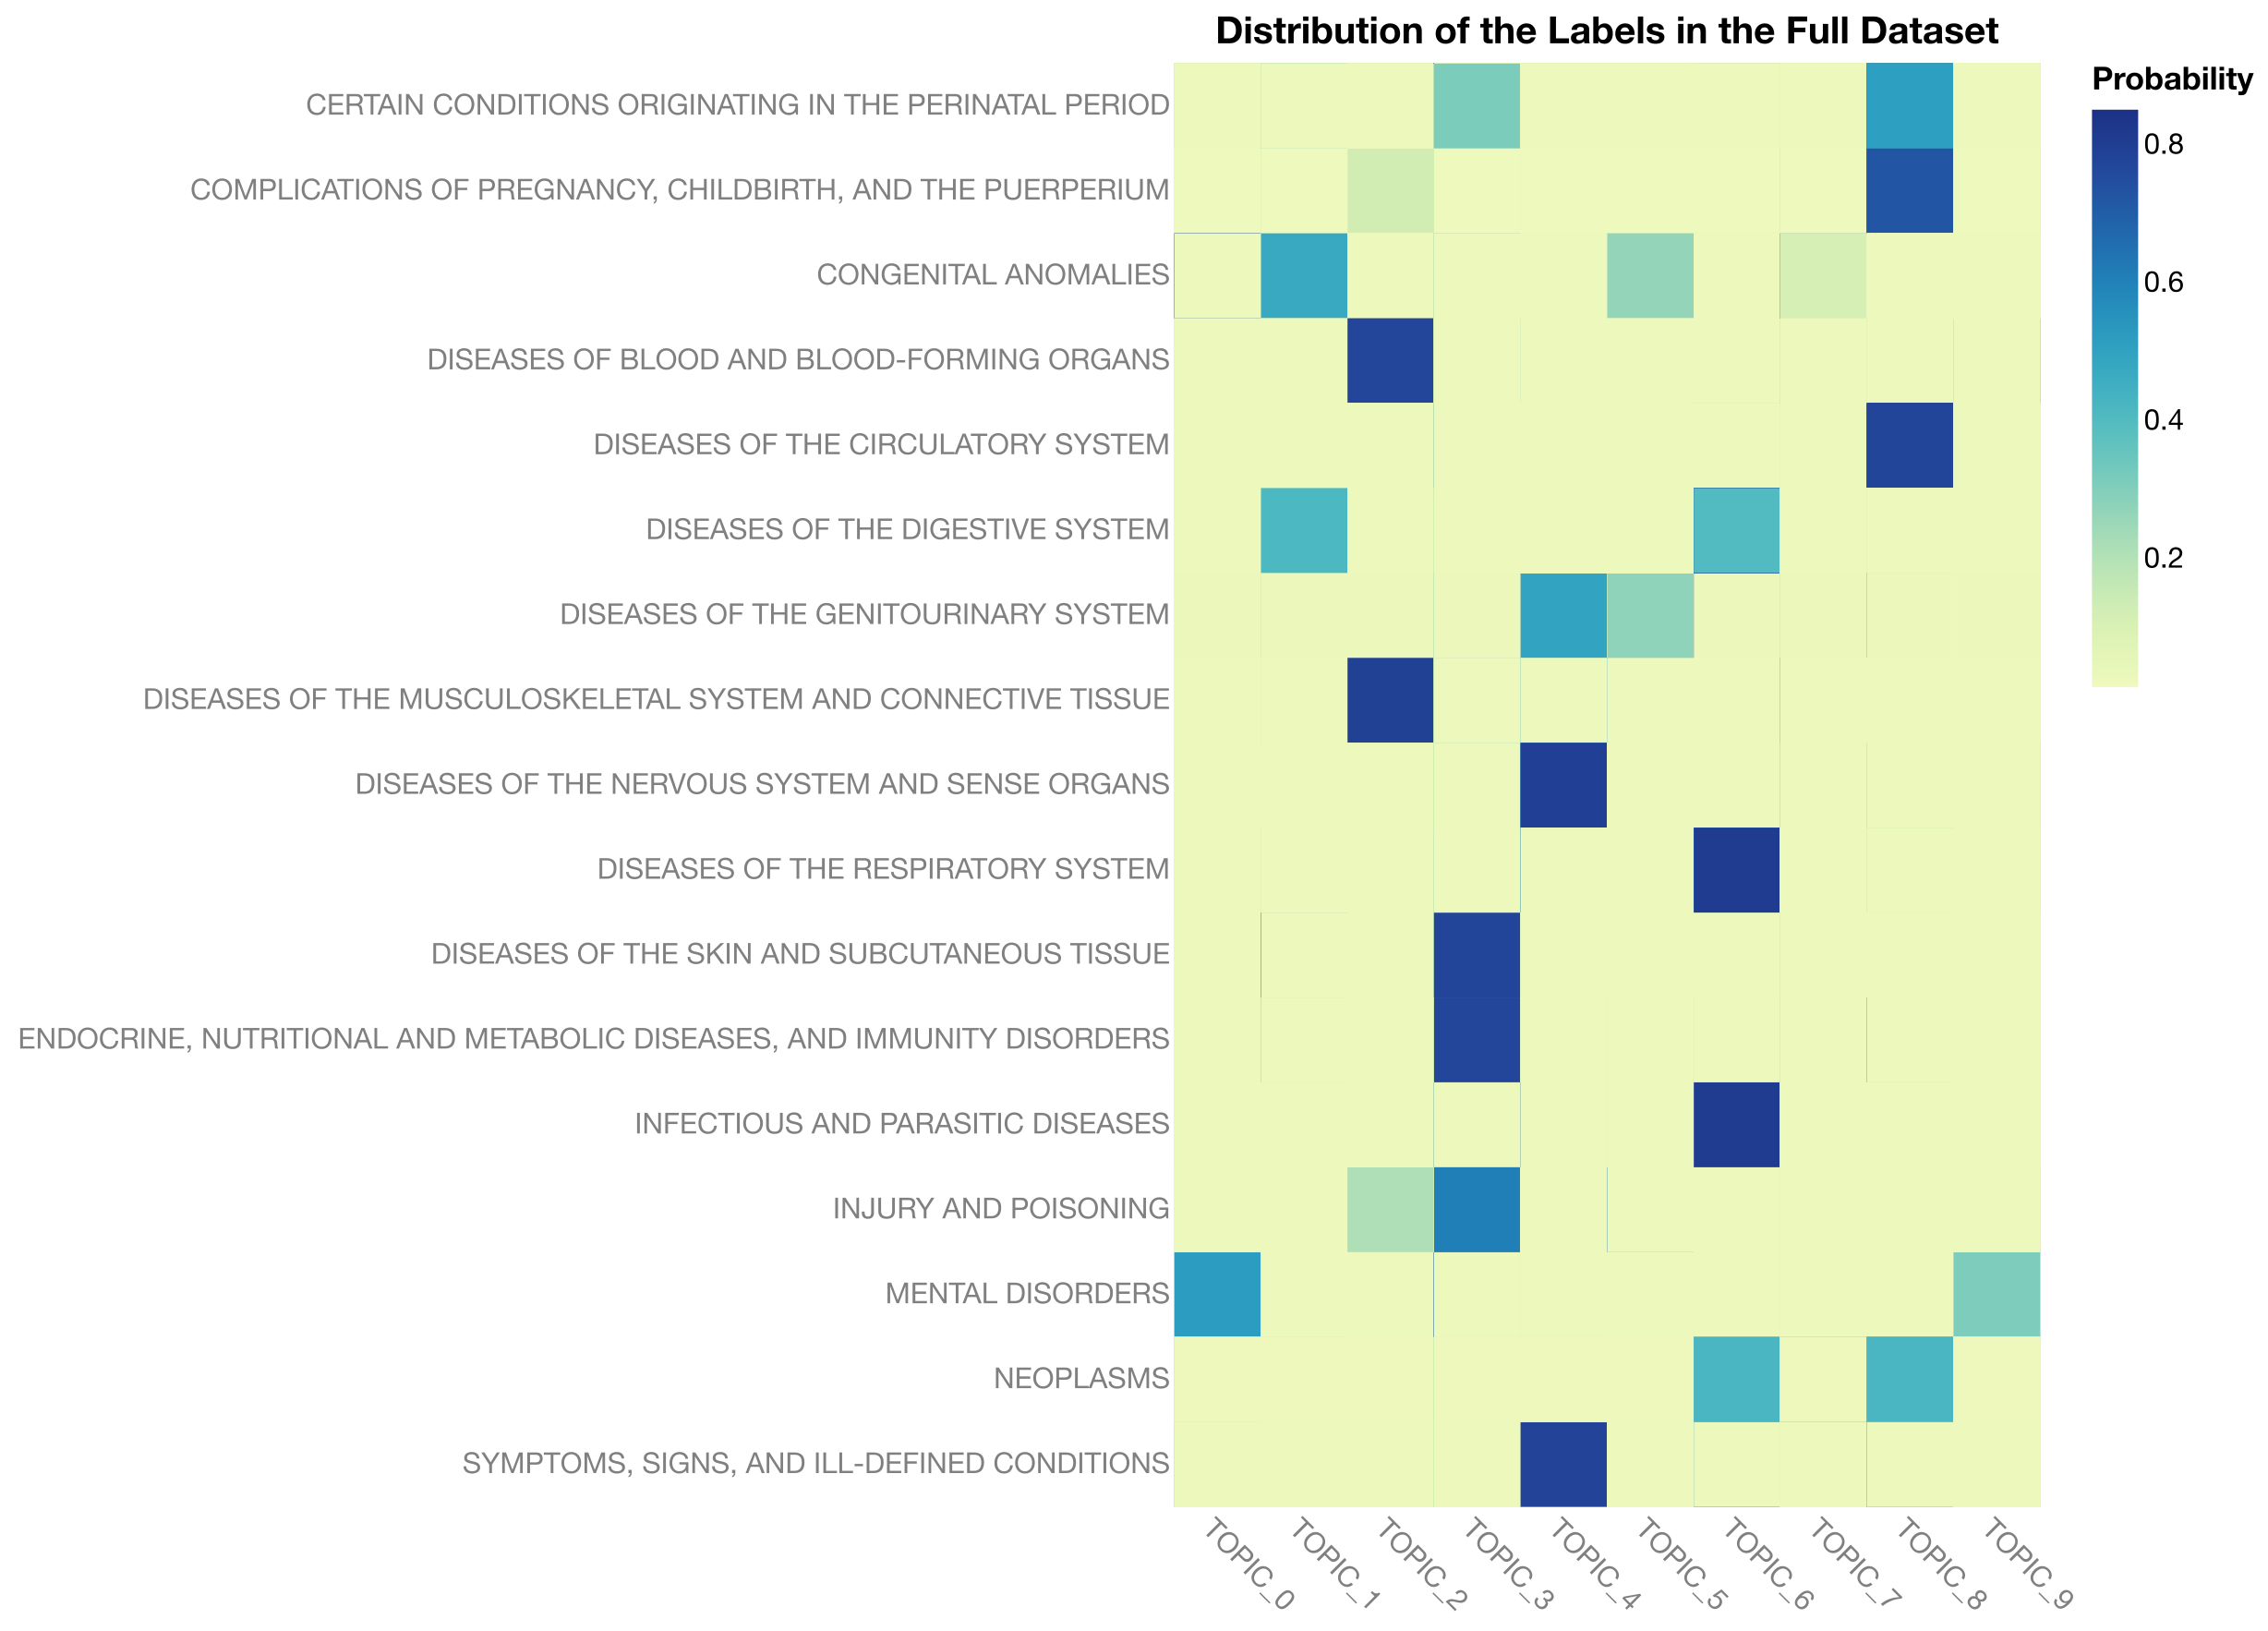

In [7]:
# Load and display the heat map of topic distributions among the labels
from IPython.display import Image
Image(filename=os.path.join(figure_path, 'full_data_topic_distribution_heatmap.png'))

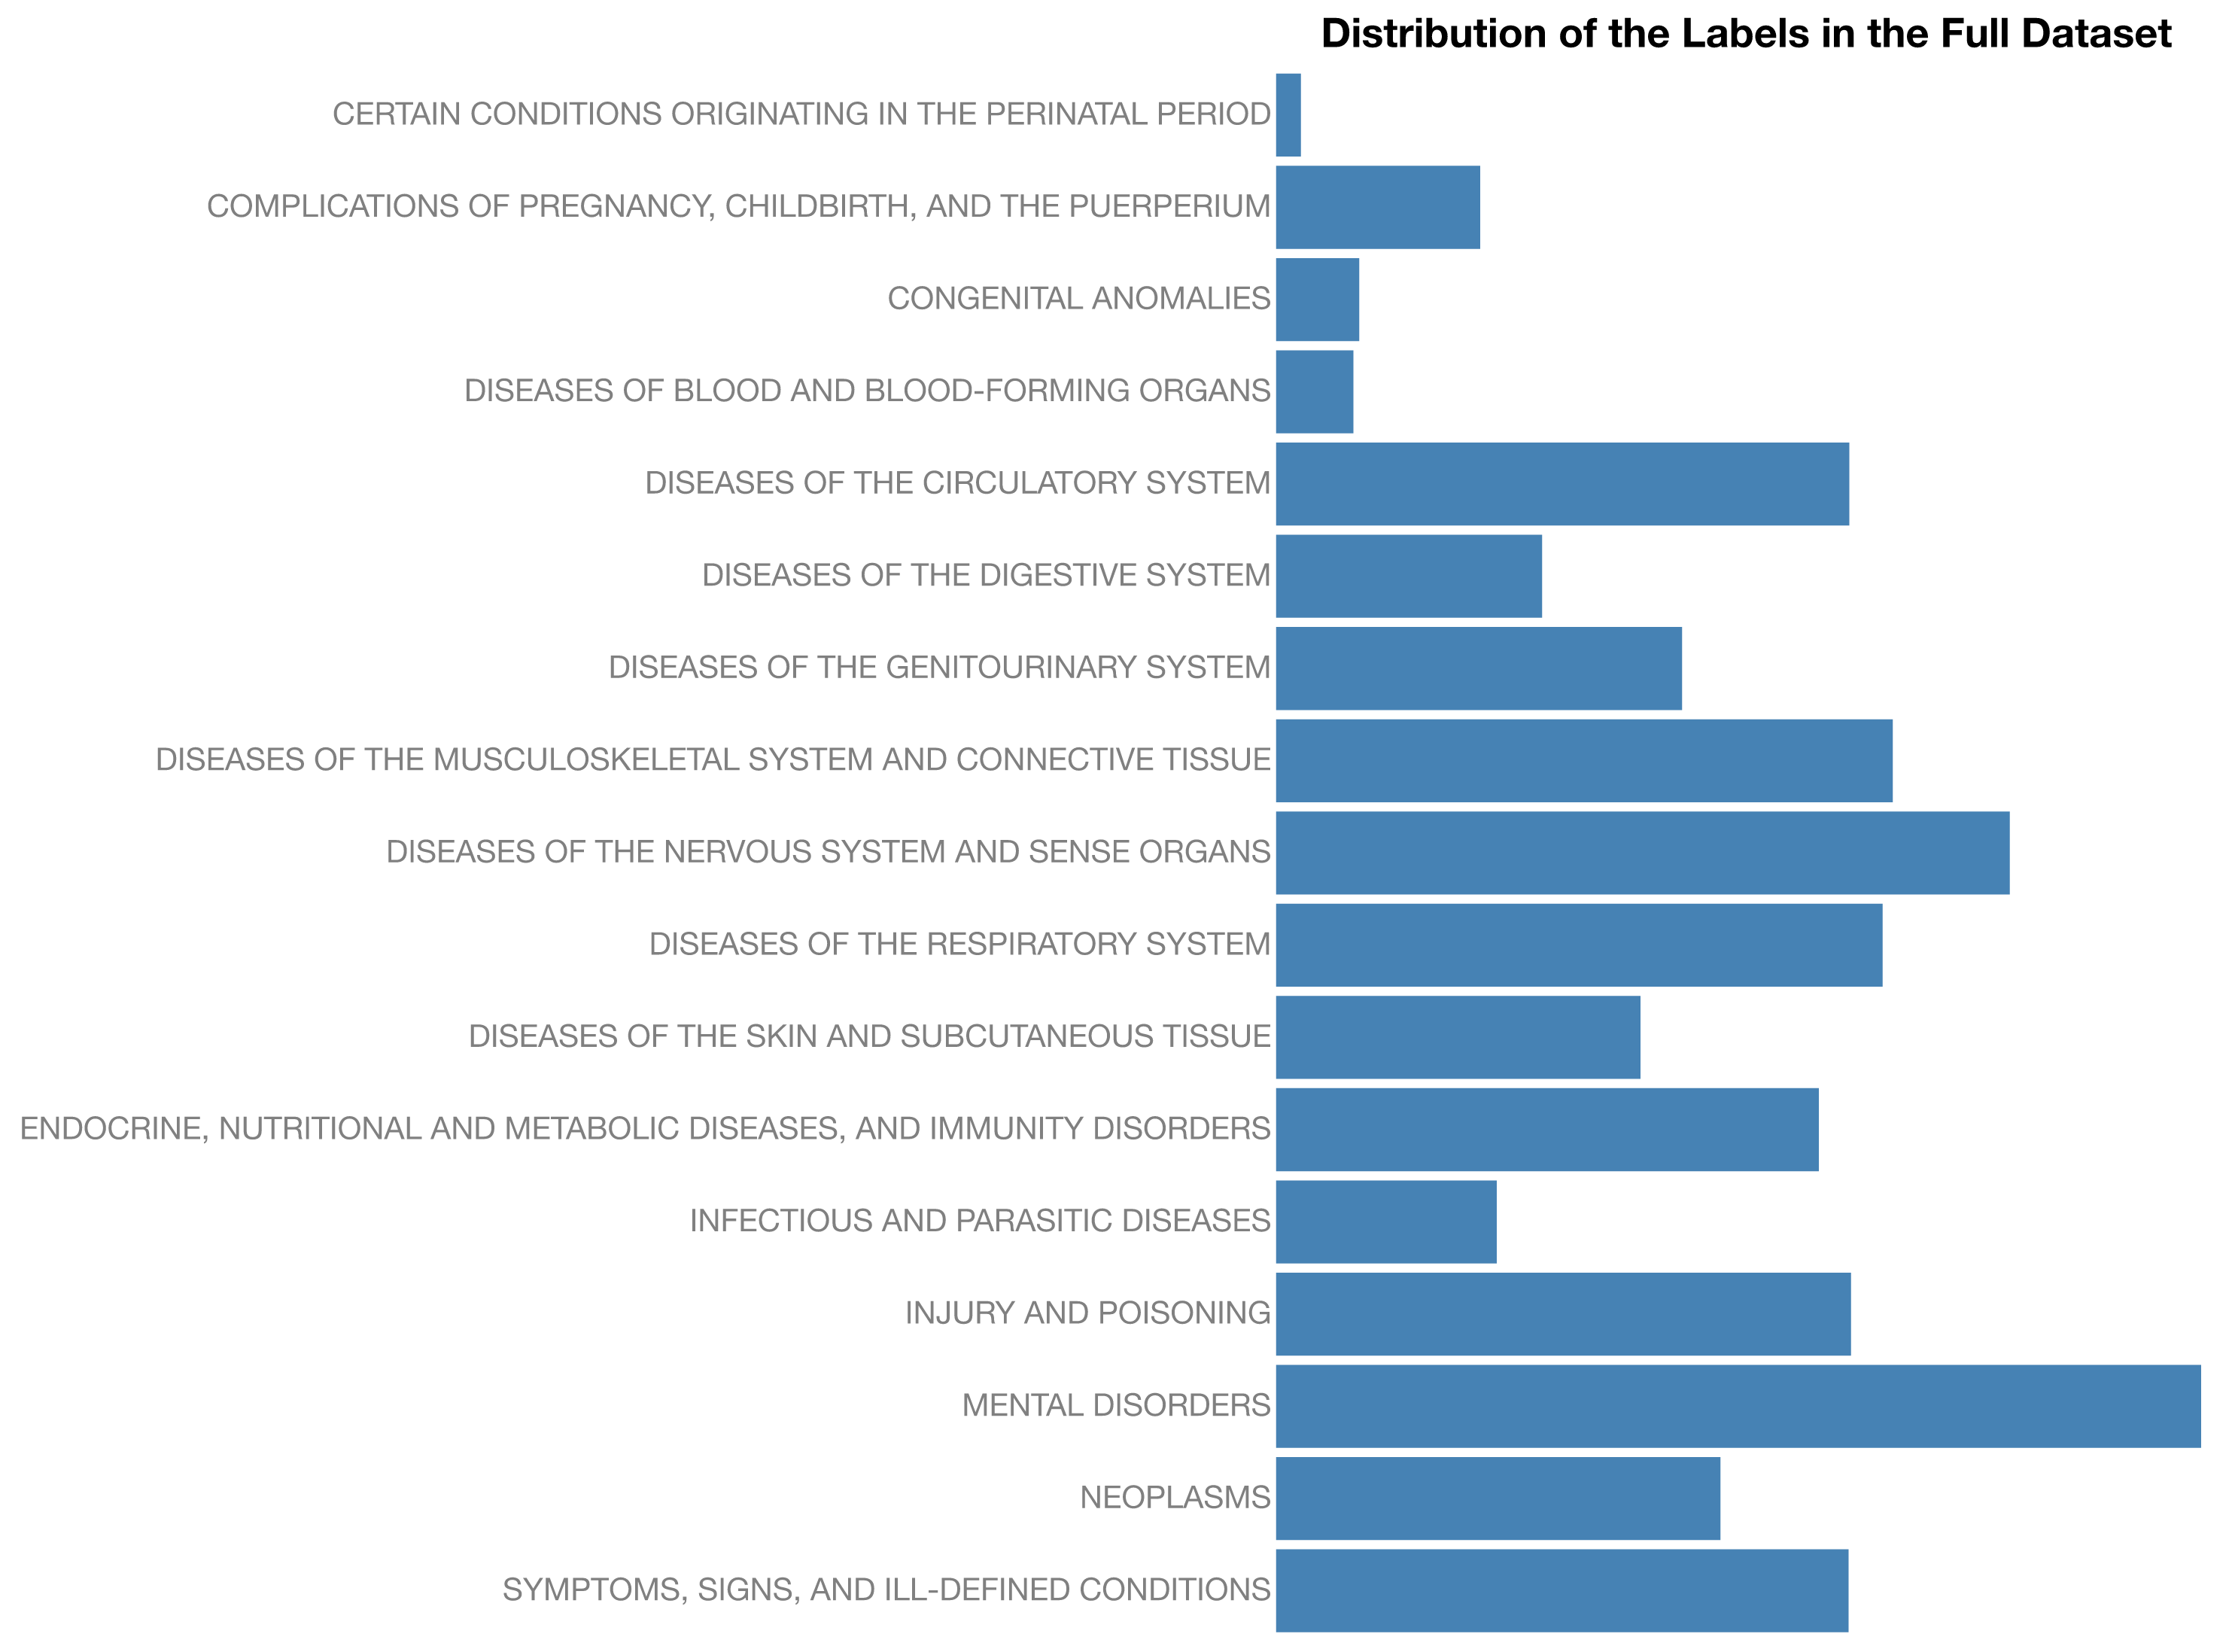

In [8]:
# Load and display the distribution and percentage of the labels
from IPython.display import Image
Image(filename=os.path.join(figure_path, 'full_data_label_distribution.png'))

## 2 - Generate word clouds for each group

In [9]:
# Plot the word cloud for each 'DIAG1_CAT' based on the average TF-IDF
if not os.path.exists(os.path.join(output_path, 'CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD_wordcloud.png')):
    import spacy
    import re

    from sklearn.feature_extraction.text import TfidfVectorizer
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    # Preprocess the text features with Spacy
    nlp = spacy.load('en_core_web_sm')

    custom_stops = ['nos', 'oth', 'nec']
    for word in custom_stops:
        nlp.vocab[word].is_stop = True

    def preprocess_text(text):
        text = re.sub(r'\bdiabete\b', 'diabetes', text)
        text = re.sub(r'\banom\b', 'anomaly', text)
        text = re.sub(r'\bsho\b', 'shoulder', text)
        text = re.sub(r'\both\b', 'other', text)
        text = re.sub(r'\buns\b', 'unspecified', text)
        
        doc = nlp(text)
        filtered_tokens = [
            token.lemma_.lower() for token in doc
            if (not token.is_stop) and (not token.is_punct)
        ]
        return ' '.join(filtered_tokens)
    
    # Process the combined text,
    # if procd_train, procd_val, procd_test and procd_final_eval are loaded
    if 'topic_features' in globals():
        procd_data['ProcessedText'] = procd_data['TEXT'].apply(lambda row: preprocess_text(preprocess_text(row)))
        procd_data.to_parquet(os.path.join(processed_data_path, 'procd_data_w_combined_text.parquet'))

    procd_data.ProcessedText.head()

    # Calculate term frequencies

    # Method 1
    # Calculate the TF-IDF for each group,
    # taking the ProcessedText of each group as the documents,
    # and the ProcessedText of the entire dataset as the corpus

    group_text = procd_data.groupby('DIAG1_CAT')['ProcessedText'].apply(lambda row: '. '.join(row)).reset_index()

    vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=1000, min_df=5, max_df=0.7)
    tfidf_matrix = vectorizer.fit_transform(group_text['ProcessedText'])

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    group_tfidf = pd.concat([group_text['DIAG1_CAT'], tfidf_df], axis=1).groupby('DIAG1_CAT').mean()

    group_tfidf.shape

    # Method 2
    # Calculate the TF-IDF of each row within each group
    # Calculate the average TF-IDF for each group

    #vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=None, min_df=5, max_df=0.7)
    #tfidf_matrix = vectorizer.fit_transform(procd_data['ProcessedText'])

    # Calculate the average TF-IDF for each cluster
    #tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    #group_tfidf = pd.concat([procd_data['DIAG1_CAT'], tfidf_df], axis=1).groupby('DIAG1_CAT').mean()

    #group_tfidf.shape

    # Punish the weight of '\d+_year_old' by multiplying it by 0.5, using the regex pattern

    #tfidf_df = tfidf_df.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)
    #cluster_tfidf = cluster_tfidf.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)

    #cluster_tfidf

    for category in group_tfidf.index:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(group_tfidf.loc[category])
        wordcloud.to_file(os.path.join(output_path, f'{category}_wordcloud.png'))

## 3 - Medical pathways

### 3.1 - Define the list diagnostic/screening services and check availability

In [10]:
# diagnostic/screening services
examination = ['BREAST', 'PELVIC', 'SKIN', 'DEPRESS']
print('examination:', examination)

imaging = ['XRAY', 'BONEDENS', 'CATSCAN', 'ULTRASND', 'MAMMO', 'MRI']
print('imaging:', imaging)

bloodTest = ['CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA']
print('bloodTest:', bloodTest)

otherTest = ['BIOPSY', 'CHLAMYD', 'EKG', 'HPVDNA', 'PAP', 'PREGTEST', 'URINE']
print('otherTest:', otherTest)

diag_screening = examination + imaging + bloodTest + otherTest

examination: ['BREAST', 'PELVIC', 'SKIN', 'DEPRESS']
imaging: ['XRAY', 'BONEDENS', 'CATSCAN', 'ULTRASND', 'MAMMO', 'MRI']
bloodTest: ['CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA']
otherTest: ['BIOPSY', 'CHLAMYD', 'EKG', 'HPVDNA', 'PAP', 'PREGTEST', 'URINE']


In [11]:
# Check the columns with 'PAP' in the column name
procd_data.columns[procd_data.columns.str.contains('PAP')]

# Assign 1 to the 'PAP' column if any of the 'PAP' related columns are 1
procd_data['PAP'] = procd_data[procd_data.columns[procd_data.columns.str.contains('PAP')]].max(axis=1)

In [12]:
# Check the count and percentage of missing values for each feature in 'diag_screening'
missing_values = procd_data[diag_screening].isna().sum().reset_index()
missing_values.columns = ['Feature', 'MissingValues']
missing_values['MissingPercentage'] = missing_values['MissingValues'] / procd_data.shape[0]
missing_values.where(missing_values['MissingValues'] > 0).dropna()

Feature  MissingValues  MissingPercentage
6    CATSCAN        27067.0           0.172597
20  PREGTEST        27067.0           0.172597

In [13]:
procd_data['DIAG1_CAT'].value_counts()

DIAG1_CAT
MENTAL DISORDERS                                                         20049
DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS                          15901
DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE             13366
DISEASES OF THE RESPIRATORY SYSTEM                                       13145
INJURY AND POISONING                                                     12461
DISEASES OF THE CIRCULATORY SYSTEM                                       12423
SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS                              12407
ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS    11763
NEOPLASMS                                                                 9630
DISEASES OF THE GENITOURINARY SYSTEM                                      8799
DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE                              7896
DISEASES OF THE DIGESTIVE SYSTEM                                          5766
INFECTIOUS AND PARASITIC DISEASES         

In [14]:
# Group by 'DIAG1_CAT' and check the count and percentage of missing values for each feature in 'diag_screening' for each group
missing_features = missing_values.loc[missing_values['MissingValues'] > 0, 'Feature'].values

missing_values_group = procd_data.groupby('DIAG1_CAT')[missing_features].apply(lambda row: row.isna().sum()).astype(float).reset_index()

missing_values_group.iloc[:, 1:] = missing_values_group.iloc[:, 1:].div(procd_data.groupby('DIAG1_CAT').size().reset_index(drop=True), axis=0)

missing_values_group

DIAG1_CAT   CATSCAN  PREGTEST
0   CERTAIN CONDITIONS ORIGINATING IN THE PERINATA...  0.152700  0.152700
1   COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND TH...  0.148960  0.148960
2                                CONGENITAL ANOMALIES  0.245556  0.245556
3          DISEASES OF BLOOD AND BLOOD-FORMING ORGANS  0.189964  0.189964
4                  DISEASES OF THE CIRCULATORY SYSTEM  0.140868  0.140868
5                    DISEASES OF THE DIGESTIVE SYSTEM  0.173257  0.173257
6                DISEASES OF THE GENITOURINARY SYSTEM  0.192067  0.192067
7   DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CON...  0.170283  0.170283
8     DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS  0.178920  0.178920
9                  DISEASES OF THE RESPIRATORY SYSTEM  0.198859  0.198859
10       DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE  0.154762  0.154762
11  ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES,...  0.184987  0.184987
12                  INFECTIOUS AND PARASITIC DISEASES  0.199749  0.199749
13                               INJURY AND POISONING  0.173180  0.173180
14                                   MENTAL DISORDERS  0.162252  0.162252
15                                          NEOPLASMS  0.149637  0.149637
16        SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS  0.176271  0.176271

In [15]:
# Drop the rows that have missing values in any of 'diag_screening'
non_missing_mask = procd_data[diag_screening].notna().all(axis=1)
procd_data = procd_data.loc[non_missing_mask]

### 3.2 - Possibilities of sevices arranged for each 'DIAG1_CAT1' group

In [16]:
# Group by 'DIAG1_CAT', check the percentage for the value in each feature of 'diag_screening' equals to 1
positive_values_group = procd_data.groupby('DIAG1_CAT')[diag_screening].mean().reset_index()
positive_values_group.head()

DIAG1_CAT    BREAST    PELVIC  \
0  CERTAIN CONDITIONS ORIGINATING IN THE PERINATA...  0.026374  0.037363   
1  COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND TH...  0.075432  0.246215   
2                               CONGENITAL ANOMALIES  0.022828  0.032401   
3         DISEASES OF BLOOD AND BLOOD-FORMING ORGANS  0.025074  0.026549   
4                 DISEASES OF THE CIRCULATORY SYSTEM  0.017052  0.018364   

       SKIN   DEPRESS      XRAY  BONEDENS   CATSCAN  ULTRASND     MAMMO  ...  \
0  0.279121  0.000000  0.054945  0.000000  0.006593  0.004396  0.002198  ...   
1  0.057105  0.014608  0.014608  0.000000  0.002656  0.052855  0.005578  ...   
2  0.153903  0.002946  0.128866  0.002209  0.040501  0.064801  0.002209  ...   
3  0.121681  0.011799  0.029499  0.003687  0.027286  0.011799  0.006637  ...   
4  0.175958  0.010681  0.047690  0.007402  0.015834  0.050876  0.020800  ...   

       HGBA   CHOLEST       PSA    BIOPSY   CHLAMYD       EKG    HPVDNA  \
0  0.026374  0.010989  0.000000  0.000000  0.002198  0.046154  0.000000   
1  0.062948  0.035857  0.000000  0.003187  0.062683  0.011421  0.016999   
2  0.016200  0.018409  0.004418  0.002209  0.001473  0.064801  0.000736   
3  0.088496  0.054572  0.005900  0.025811  0.007375  0.025074  0.001475   
4  0.069053  0.136606  0.025297  0.006559  0.002623  0.086199  0.001593   

        PAP  PREGTEST     URINE  
0  0.000000  0.000000  0.030769  
1  0.050199  0.028951  0.376627  
2  0.004418  0.000736  0.045655  
3  0.009587  0.001475  0.062684  
4  0.012555  0.001124  0.058278  

[5 rows x 23 columns]

### 3.3 - Plot the possibilities of sevices arranged

In [17]:
# Transform the `procd_data` to a long format for the 'diag_screening' features and 'DIAG1_CAT'
diag_screening_df = procd_data[['DIAG1_CAT'] + diag_screening].melt(id_vars='DIAG1_CAT', var_name='Service', value_name='Value')

diag_screening_df

DIAG1_CAT Service  Value
0        DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS  BREAST    0.0
1        DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS  BREAST    0.0
2                                              NEOPLASMS  BREAST    0.0
3            SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS  BREAST    0.0
4        DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS  BREAST    0.0
...                                                  ...     ...    ...
2854605                 DISEASES OF THE DIGESTIVE SYSTEM   URINE    0.0
2854606                 DISEASES OF THE DIGESTIVE SYSTEM   URINE    0.0
2854607                                        NEOPLASMS   URINE    0.0
2854608                 DISEASES OF THE DIGESTIVE SYSTEM   URINE    0.0
2854609                                        NEOPLASMS   URINE    0.0

[2854610 rows x 3 columns]

In [18]:
# Replace the 'Feature' values with the corresponding full names
diag_screening_df['Service'] = diag_screening_df['Service'].replace({
    'BREAST': 'Breast Exam',
    'PELVIC': 'Pelvic Exam',
    'SKIN': 'Skin Exam',
    'DEPRESS': 'Depression Screening Exam',
    'XRAY': 'X-Ray',
    'BONEDENS': 'Bone Mineral Density',
    'CATSCAN': 'CT Scan',
    'ULTRASND': 'Ultrasound',
    'MAMMO': 'Mammography',
    'MRI': 'MRI',
    'CBC': 'Complete Blood Count',
    'GLUCOSE': 'Glucose',
    'HGBA': 'HgbA1C (Glycohemoglobin)',
    'CHOLEST': 'Lipids/Cholesterol',
    'PSA': 'PSA (Prostate Specific Antigen)',
    'BIOPSY': 'Biopsy',
    'CHLAMYD': 'Chlamydia test',
    'EKG': 'EKG/ECG',
    'HPVDNA': 'HPV DNA Test',
    'PAP': 'Pap Smear',
    'PREGTEST': 'Pregnancy/HCG Test',
    'URINE': 'Urinalysis (UA)'
})

In [19]:
# Plot the error bars with confidence interval for the percentage of values in each feature of 'diag_screening' equals to 1 for each group
def plot_error_bars(df, category='SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS'):
    base = alt.Chart(df).transform_filter(
        alt.FieldEqualPredicate(field='DIAG1_CAT', equal=category)
    ).encode(
        y=alt.Y('Service:N', title=None),
    )

    error_bars = base.mark_errorbar(extent='ci').encode(
        x=alt.X('Value:Q', title='Probability'), #scale=alt.Scale(zero=False)),
    )

    points = base.mark_point(filled=True).encode(
        x=alt.X('Value:Q', aggregate='mean', title='Probability'),
        tooltip=['Service']
    )

    chart = alt.layer(error_bars, points).properties(
        title=alt.Title(f'Probability of Diagnostic/Screening Services for {category}', subtitle=' ', fontSize=14, anchor='middle'),
        width=450,
        height=600,
    ).configure(
        axis=alt.AxisConfig(
            #domain=False,
            #ticks=False,
            grid=False,
            labelAngle=0,
            labelColor='gray',
            labelFontSize=12,
        ),
        font='Helvetica Neue',
        view=alt.ViewConfig(stroke=None), # remove border
    )

    return chart

In [20]:
if not os.path.exists(os.path.join(output_path, 'CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD_diag_screening_error_bars.png')):
    for category in diag_screening_df.DIAG1_CAT.unique():
        chart = plot_error_bars(diag_screening_df, category)
        chart.save(os.path.join(output_path, f'{category}_diag_screening_error_bars.png'), ppi=300)
else:
    list_of_error_bars = [file for file in os.listdir(output_path) if 'diag_screening_error_bars' in file]
    #for file in list_of_error_bars:
    #    display(Image(filename=os.path.join(output_path, file)))

## 4 - Simulation of user input, classification prediction and the output

### 4.1 - Simulate user input

In [21]:
features = [
    'AGE', 'SEX', 'USETOBAC', 
    'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 
    'PASTVIS', 
    'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 
    'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS',
    'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT'
]

In [22]:
user_input = procd_data.loc[(procd_data.AGE == 42) & (procd_data.SEX == 2), features].iloc[3].to_frame().T
user_input.T

36354
AGE                                              42
SEX                                               2
USETOBAC                                          1
INJDET                                            5
MAJOR                                             3
RFV1                                          14200
RFV2                                          14301
RFV3                                             -9
PASTVIS                                         NaN
HTIN                                           67.0
WTLB                                          205.0
BMI                                            32.1
TEMPF                                           NaN
BPSYS                                           NaN
BPDIAS                                          NaN
ARTHRTIS                                          0
ASTHMA                                            0
CANCER                                            0
CEBVD                                             0
CHF                                               0
CRF                                               0
COPD                                              0
DEPRN                                             0
DIABETES                                          0
HYPLIPID                                          0
HTN                                               0
IHD                                               0
OBESITY                                           0
OSTPRSIS                                          0
RFV1_TEXT  Labored or difficult breathing (dyspnea)
RFV2_TEXT       Disorders of respiratory sound, NEC
RFV3_TEXT                                      None

In [23]:
# Load the saved vectorizer and lda
vectorizer = joblib.load(os.path.join(model_path, 'full_data_vectorizer.joblib'))
lda = joblib.load(os.path.join(model_path, 'full_data_lda.joblib'))

In [24]:
procd_user_input = build_features.process_input(user_input, features, vectorizer, lda, transform='log')

Topic Features: ['TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9']
DataFrame Shape: (1, 54)


### 4.2 - Load the final model

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

class OptionalPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
    
    def fit(self, X, y=None):
        if self.n_components is not None:
            self.pca.fit(X)
        return self
    
    def transform(self, X):
        if self.n_components is not None:
            return self.pca.transform(X)
        return X

In [26]:
best_estimator = joblib.load(os.path.join(model_path, f'{model_name}_final_model.joblib'))
best_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', 'passthrough',
                                                  ['SEX', 'USETOBAC',
                                                   'ARTHRTIS', 'ASTHMA',
                                                   'CANCER', 'CEBVD', 'CHF',
                                                   'CRF', 'COPD', 'DEPRN',
                                                   'DIABETES', 'HYPLIPID',
                                                   'HTN', 'IHD', 'OBESITY',
                                                   'OSTPRSIS']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['INJDET', 'MAJOR', 'RFV1',
                                                   'RFV2', 'RFV3', 'RFV1_MOD1',
                                                   'RFV2_MOD1', 'RFV3_MOD1',
                                                   'RFV1_MOD2', 'RFV2_MOD2',
                                                   'RFV3_MOD2'])])),
                ('scaler', StandardScaler()), ('pca', OptionalPCA()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='log2',
                                        min_samples_split=10, n_estimators=1000,
                                        n_jobs=-1, random_state=42))])

### 4.3 - Prediction and Outputs

In [27]:
# Check the top 3 probabilities of the predicted label
user_pred_proba = best_estimator.predict_proba(procd_user_input)
top_3_proba = np.sort(user_pred_proba[0])[::-1][:3]
top_3_labels = best_estimator.classes_[np.argsort(user_pred_proba[0])[::-1][:3]]

for label, proba in zip(top_3_labels, top_3_proba):
    print(f'Label: {label}, Probability: {proba:.3f}')

Label: DISEASES OF THE RESPIRATORY SYSTEM, Probability: 0.318
Label: DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS, Probability: 0.299
Label: SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS, Probability: 0.174


In [28]:
# Plot a horizontal bar chart for the top 3 predicted labels
top_3_pred_df = pd.DataFrame({'Label': top_3_labels, 'Probability': top_3_proba})

build_features.chart(
    df=top_3_pred_df,
    x='Probability:Q',
    y='Label:N',
    title=alt.Title('Top 3 Predicted Classification of Diseases and Injuries', subtitle=' ', fontSize=14, align='right'),
).mark_bar().configure_axisY(
    labelLimit=500, title=None
).configure_axisX(
    labels=False, title=None, grid=False, labelFontSize=12,
).configure_axisY(labelFontSize=12, title=None, labelLimit=600).properties(width=300, height=200)

alt.Chart(...)

Label: DISEASES OF THE RESPIRATORY SYSTEM, Probability: 0.318


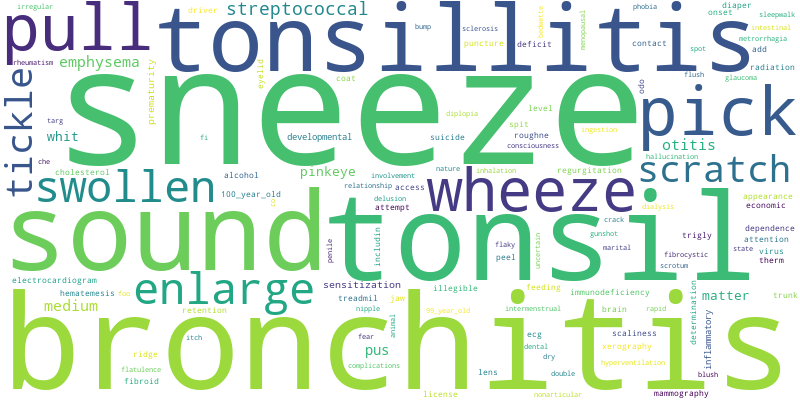

Probabilities of Diagnostic/Screening Services being received:



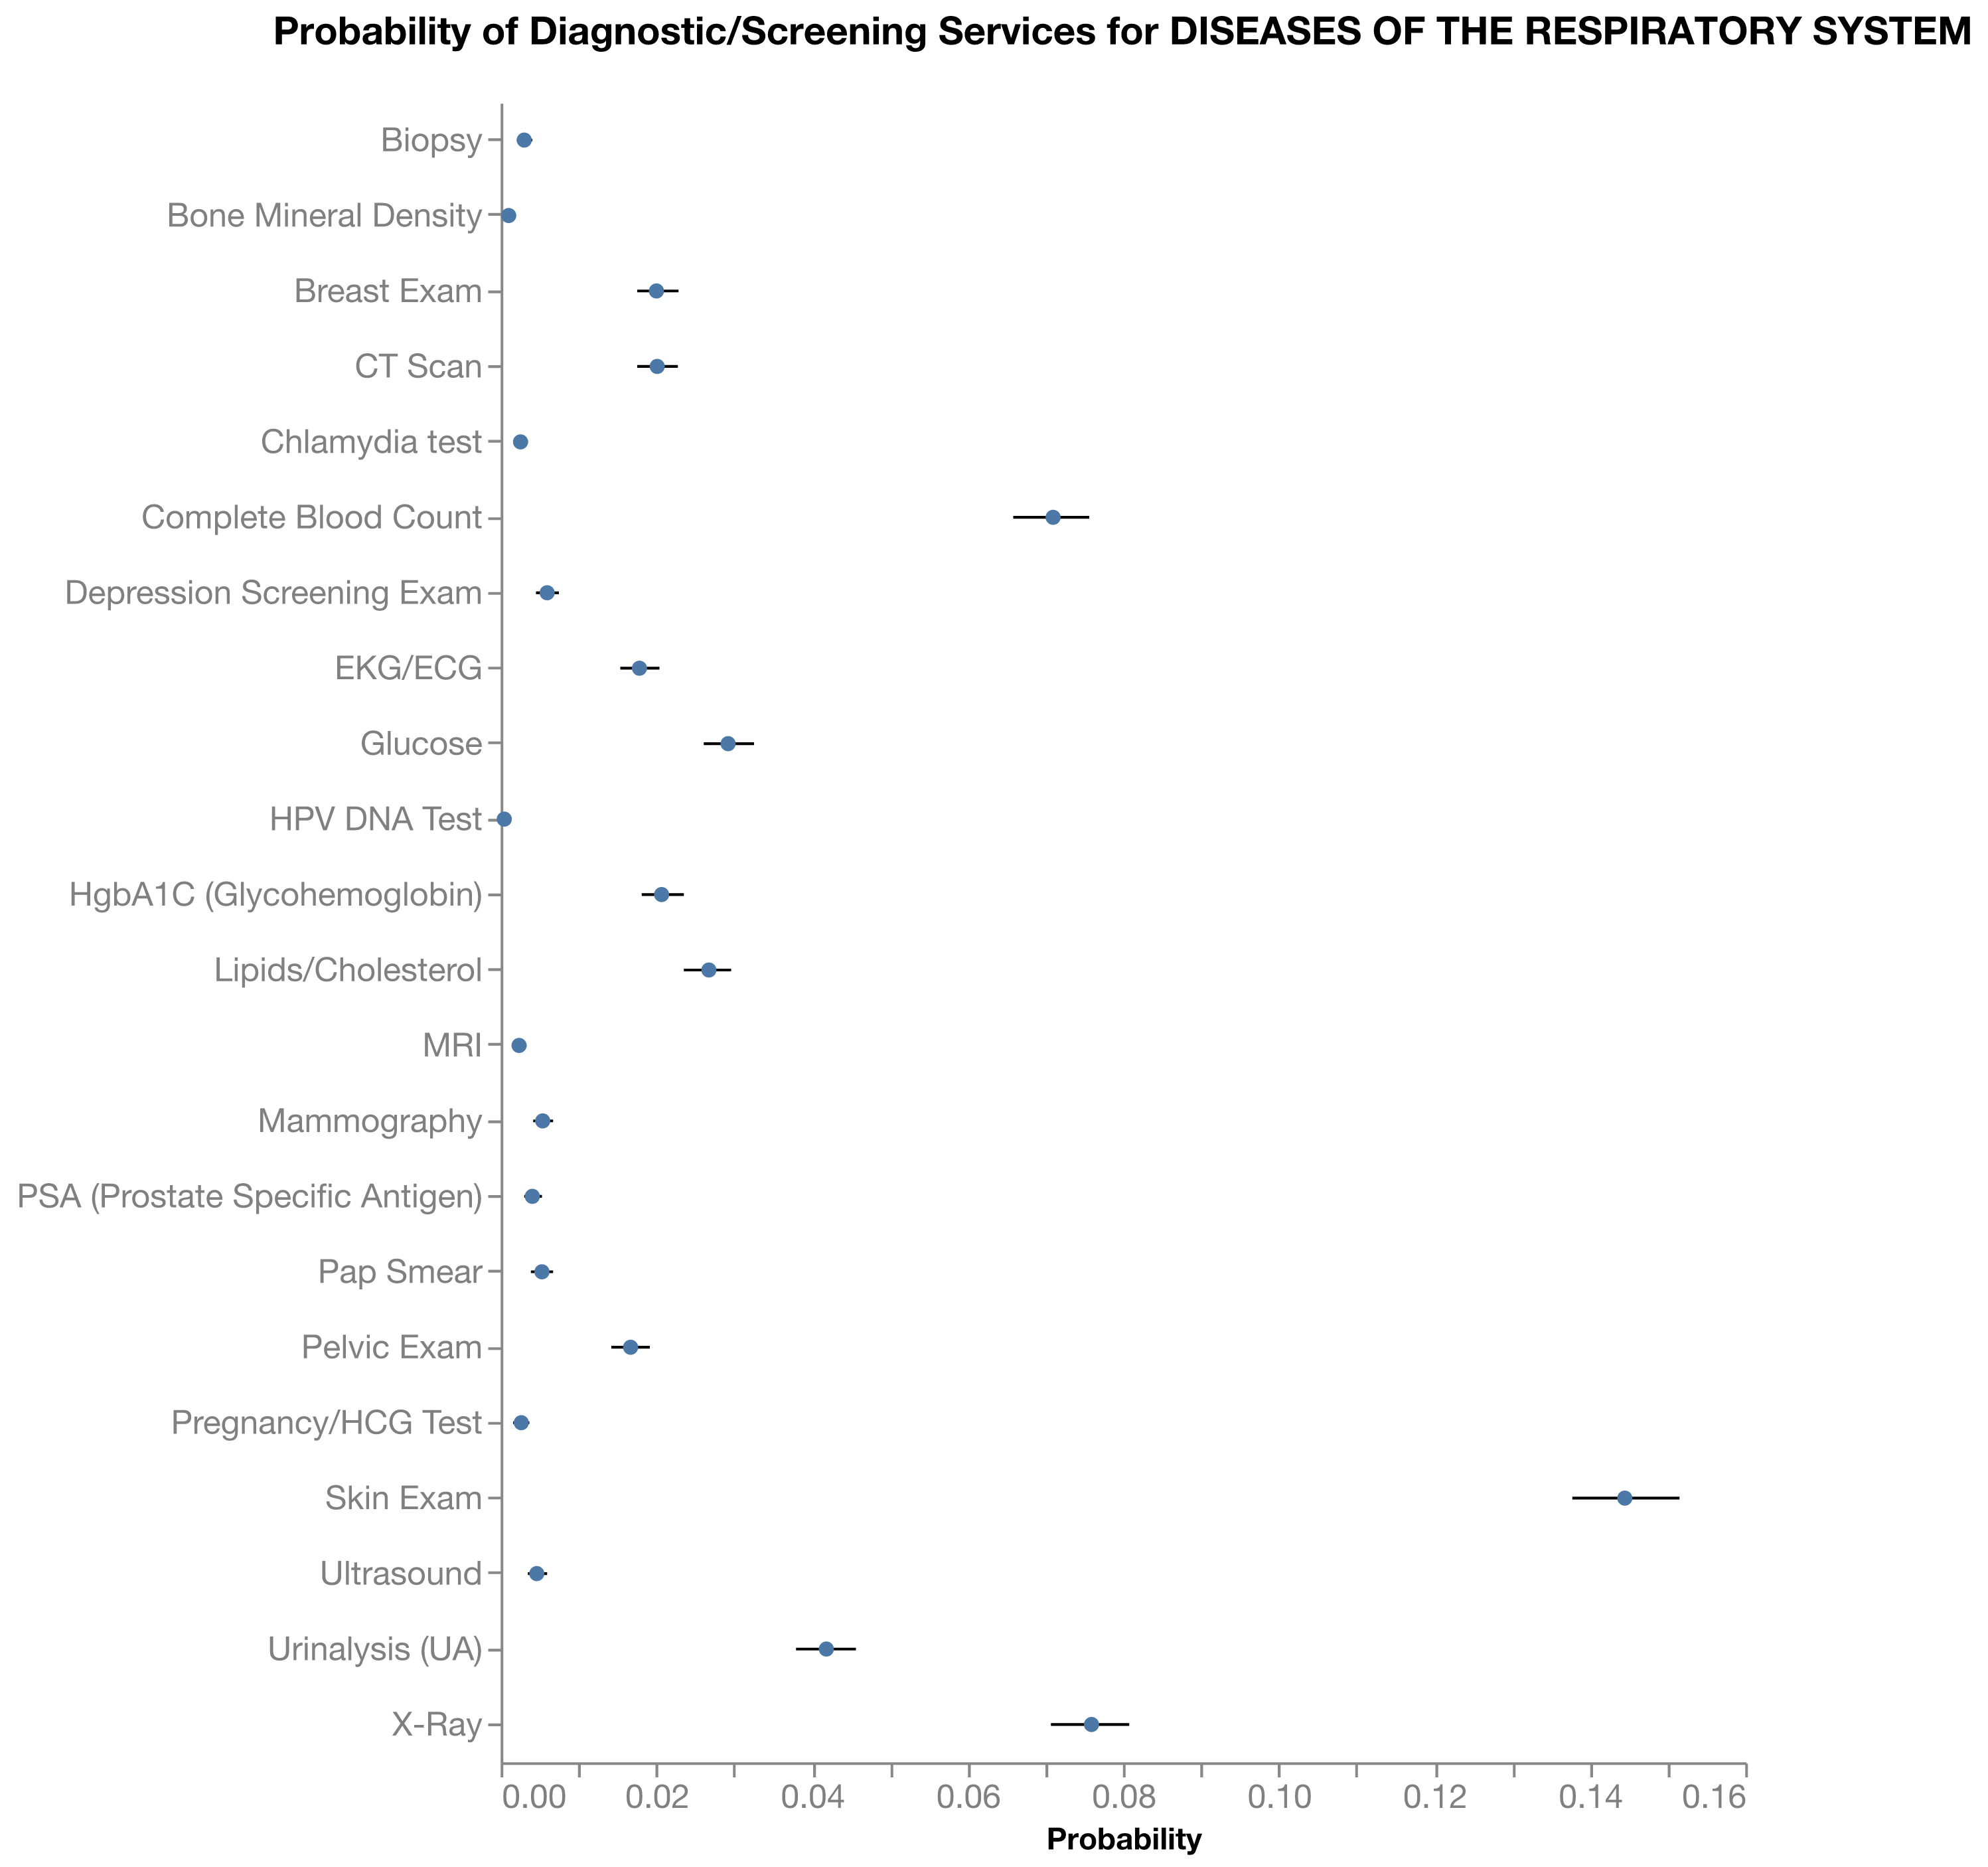

Label: DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS, Probability: 0.299


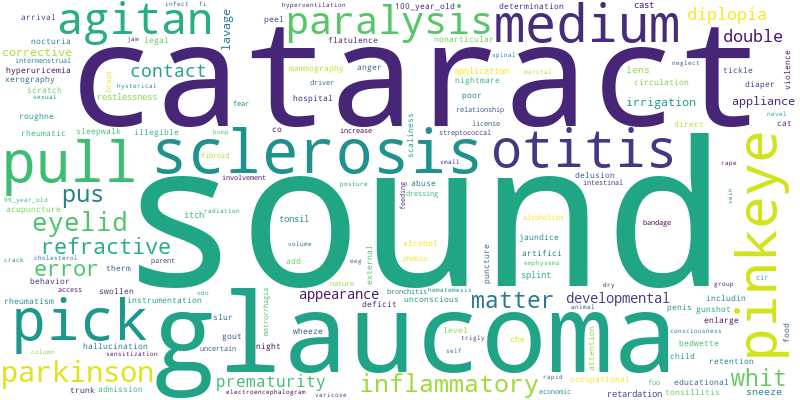

Probabilities of Diagnostic/Screening Services being received:



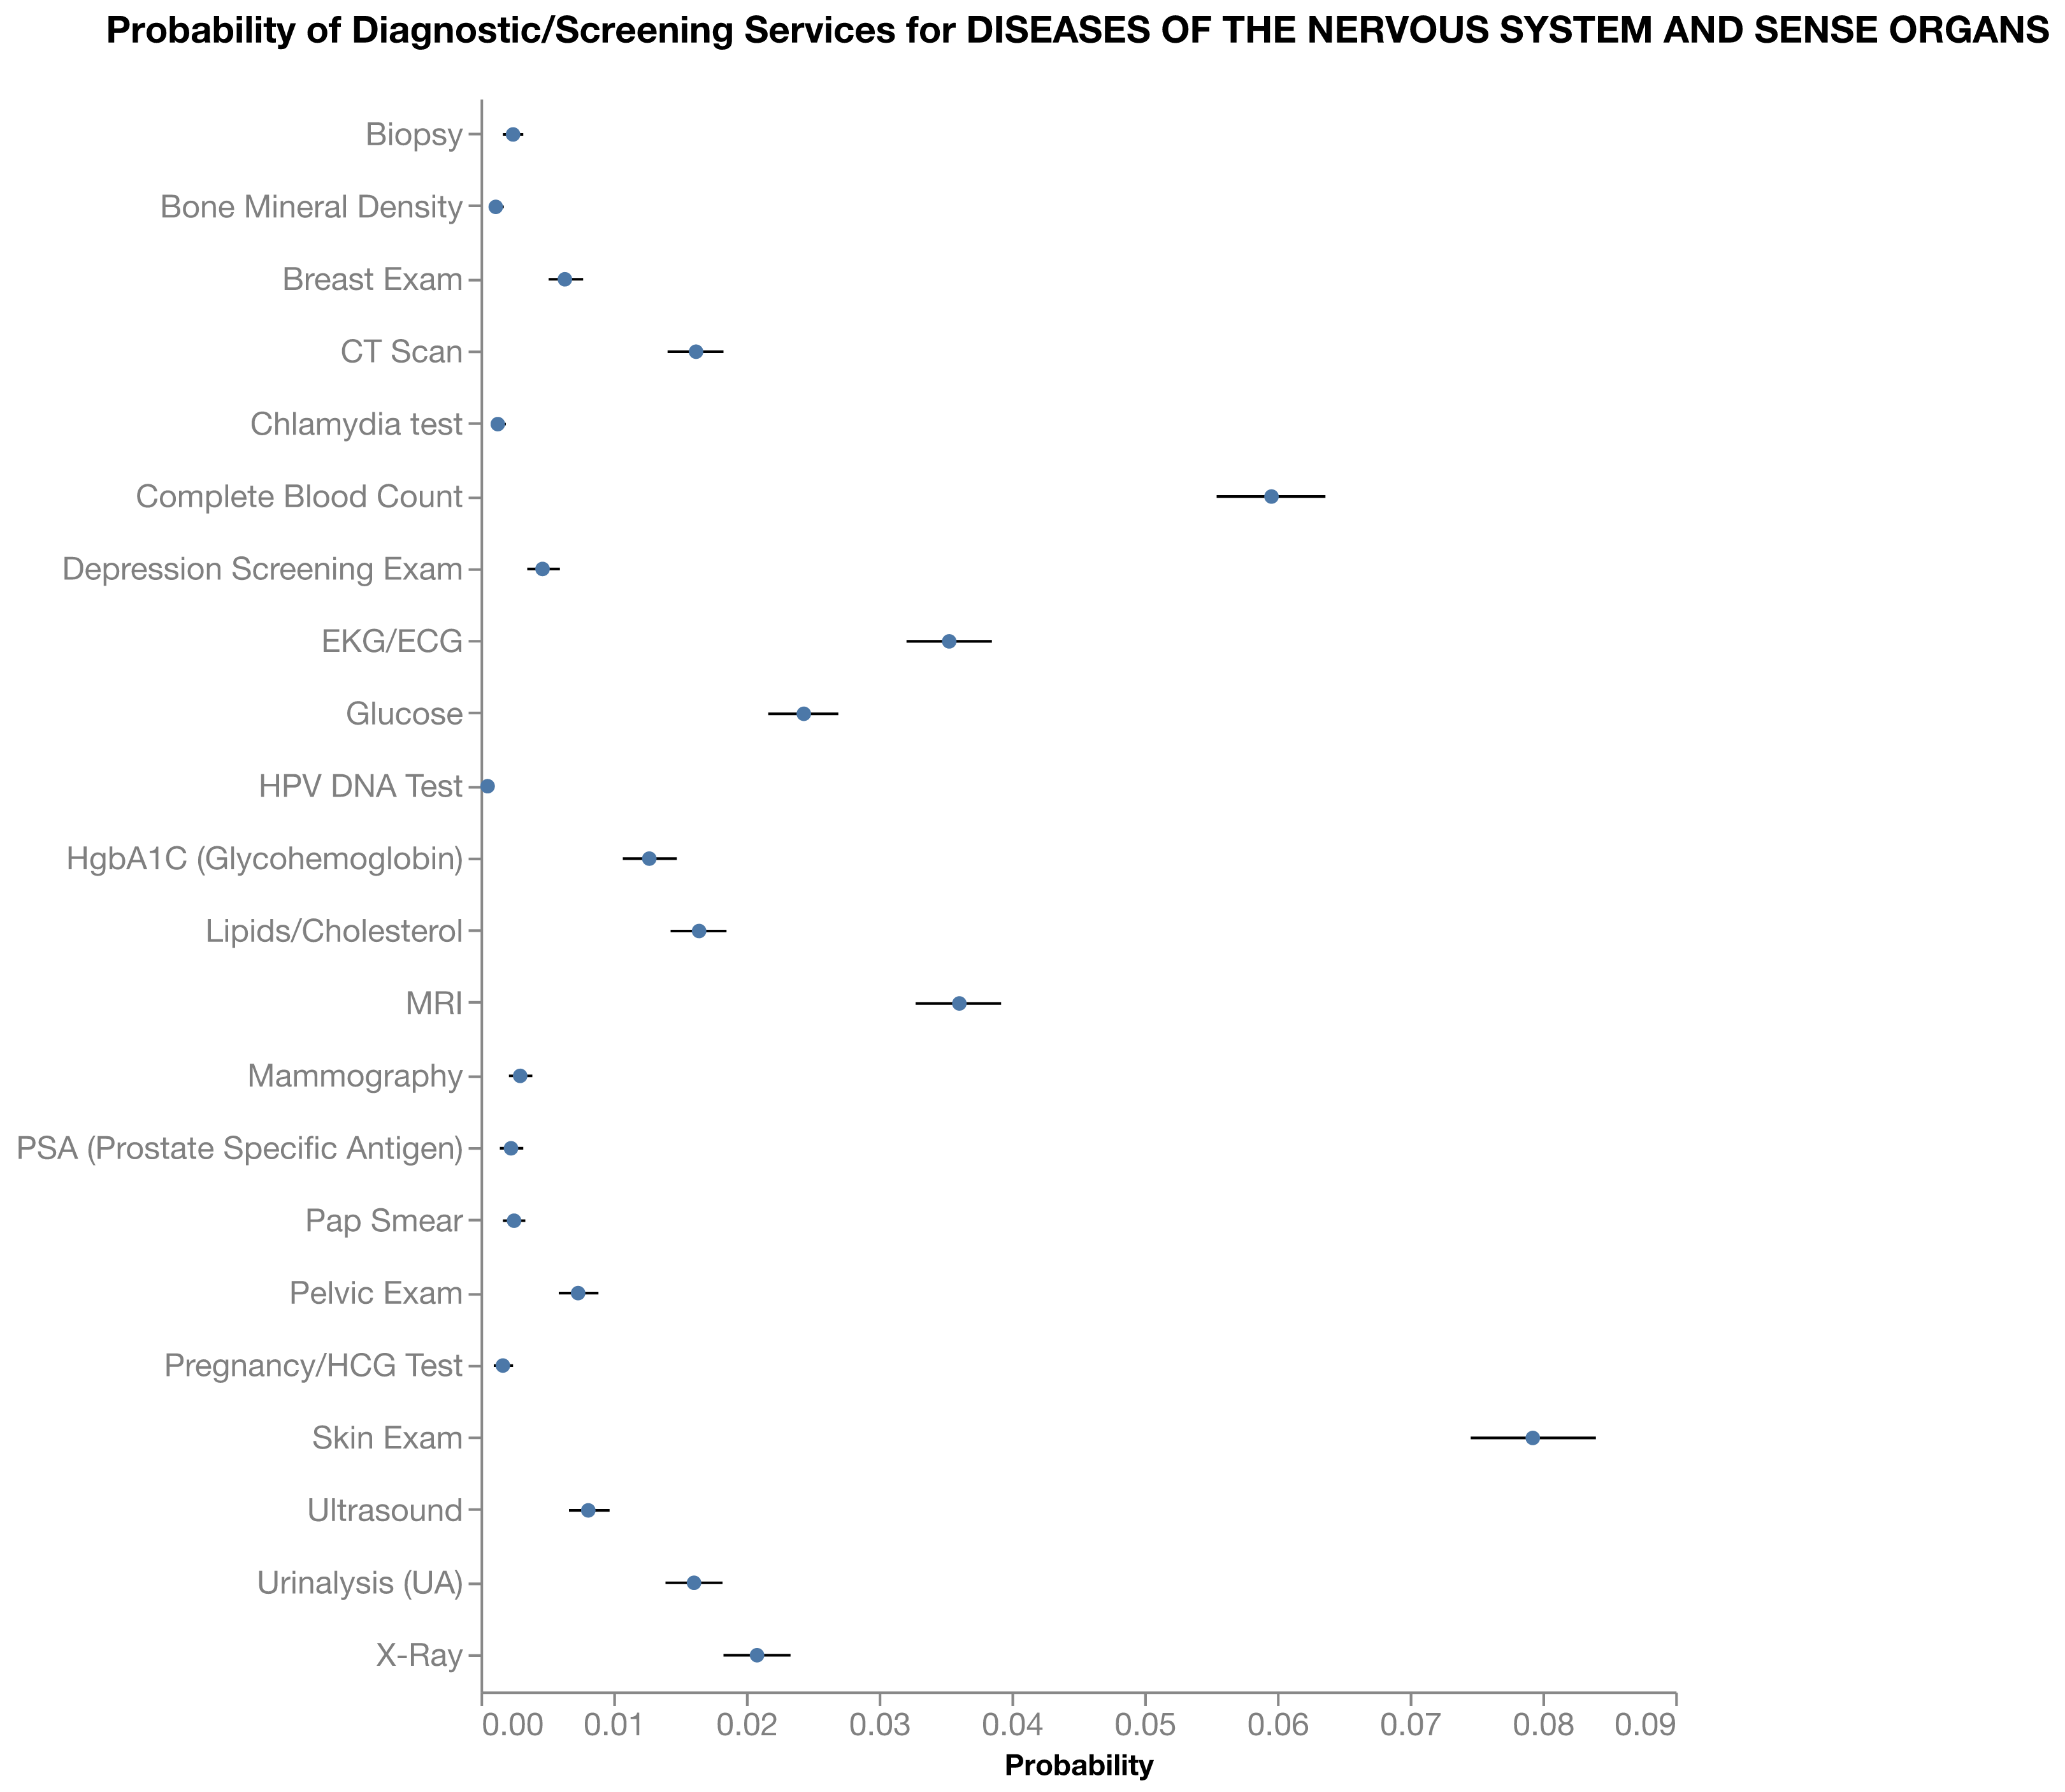

Label: SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS, Probability: 0.174


Probabilities of Diagnostic/Screening Services being received:



In [29]:
# Output the possibilities of diagnostic/screening services being received for each of the top 3 predicted labels
for label, proba in zip(top_3_labels, top_3_proba):
    print(f'Label: {label}, Probability: {proba:.3f}')

    # Show wordcloud for the label as the hots words of the category
    from IPython.display import Image, display
    wordcloud = Image(filename=os.path.join(output_path, f'{label}_wordcloud.png'))
    display(wordcloud)

    print('Probabilities of Diagnostic/Screening Services being received:')
    print()
    
    # Shwo the Probability of Diagnostic/Screening Services for the label
    #plot_error_bars(diag_screening_df, label).display()
    error_bars = Image(filename=os.path.join(output_path, f'{label}_diag_screening_error_bars.png'))
    display(error_bars)
